## Importação das bibliotecas

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pyart

import warnings
import math
from mpl_toolkits.basemap import Basemap

warnings.filterwarnings('ignore')
%matplotlib inline

### Leitura dos dados

In [22]:
xds = xr.open_dataset('data/radar/20140201/sbmn_rain_rates_20140201_110013.nc')

### Descrição das variáveis

In [23]:
xds.data_vars

Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 ...
    lon0        (y0, x0) float32 ...
    rain_rate   (y0, x0) float32 ...

#### Unidade das variáveis

In [24]:
dbz_unit = xds.DBZc.units
x0_unit = xds.x0.units
y0_unit = xds.y0.units

print('Unidade DBCc:   '+dbz_unit+ '\nUnidade de X0:  ' + x0_unit + '\nUnidade de Y0:  ' + y0_unit)

AttributeError: 'Dataset' object has no attribute 'DBZc'

#### Agregação dos valores

In [31]:
dbz = xds.rain_rate.data
lat = xds.lat0.data
lon = xds.lon0.data
x0 = xds.x0.data
y0 = xds.y0.data
# rrange = xds.range.data
# rrange = rrange[0]

# x0

### Calculo do MAXCAPPI

In [32]:
def maxCAPPI(data):
    mc = np.fmax(data[0],data[1]) 
    for i in range(2,len(data)):
        mc = np.fmax(mc,data[i])
    return mc

In [33]:
def CAPPI2km(data):
    data = data[4]
    return data

In [34]:
def cap2mmh(data):
    return data

### Dados

In [35]:
dados = maxCAPPI(dbz[0])

In [36]:
def radarRange(rrange):
    
    vrange = np.zeros(241*241)-9999
    vrange = np.reshape(vrange,(241,241)) 
    
    km = np.amax(rrange, where=~np.isnan(rrange), initial=-1)
    
    print('Max Range: ' + str(km-2))
  
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if (rrange[i][j]) < km-1:
                vrange[i][j] = np.float32('nan')
            else:
                vrange[i][j] = rrange[i][j]
                
    ## Preenche com max value
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if vrange[i][j] == -9999:
                vrange[i][j] = np.float32('nan')
    return vrange

In [37]:
def VIL(data):
    vil = 0
    Z = data[0]
   # print (Z)
    for i in range(len(Z-1)):
        #vil = 3.44*10**(-6)*(((Z[i] + Z[i+1])/2)**(4/7))*0.5
        print("Nível: " + str([i]) + " " + str(Z[i+1]) + "")
    
    return vil

In [39]:
maxrange = radarRange(rrange[39])

NameError: name 'rrange' is not defined

### Plot MAXCAPPI

ValueError: not enough values to unpack (expected 2, got 0)

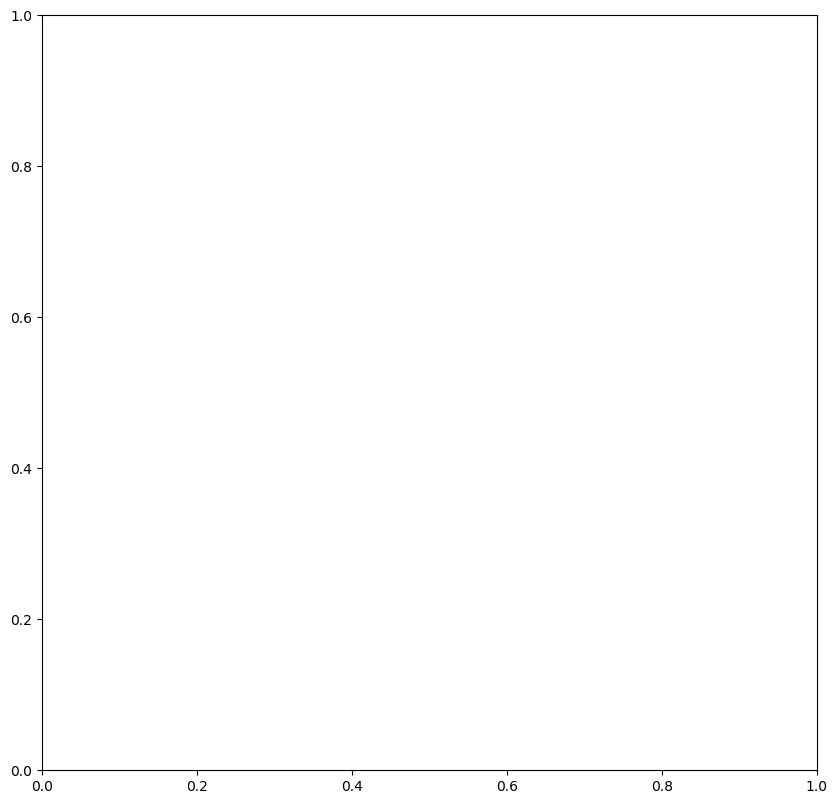

In [43]:
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                        ## ZOOM SCALE


bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
        my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
label = 'Radar Reflectivity Factor '
title = 'Maxx CAPPI'

levs = np.linspace(0,80,41,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)
cmap = 'pyart_NWSRef'
ax = axes

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

xi, yi = m(lon, lat)
xm, ym = m(my_coords[1],my_coords[0])


#m.pcolormesh(xi,yi,maxrange)

cs = m.pcolormesh(xi,yi,dados,norm=norm,cmap=cmap,ax=ax)
m.plot(xm,ym, marker='x',color='k')


# # # # Add Grid Lines
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
#m.drawmapboundary(fill_color='green')

m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')

# # # # # Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(label)

# # # # # Add Title
plt.title(title)
plt.ylabel('Longitude', labelpad=40)
plt.xlabel('Latitude', labelpad=60)

plt.show()

In [44]:
import gzip

f = gzip.GzipFile('./R12345678_201402010048.raw.gz')
event_dtype = np.dtype('float32')
s = f.read()
event = np.frombuffer(s, dtype=event_dtype)

output = np.array(event)
output = np.reshape(output, (241,241))
np.savetxt("./R12345678_201402010048.csv", output, delimiter=",")

In [46]:
np.amin(output)

-99.0